# Train Models

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

RANDOM_STATE = 80402

Import data

In [2]:
# read in the data
data = pd.read_csv("data/FlexiCombo.csv")

# drop any rows with missing data
data.dropna(inplace=True)

# extract the features (Voltages) and target (Symbol)
X = data.iloc[:, 1:].values
y = data["symbol"].values

data

,symbol,0,1,2,3,4
0,baseline,0.0,0.0,0.0,0.0000,0.0000
1,baseline,0.0,0.0,0.0,0.0000,0.0000
2,baseline,0.0,0.0,0.0,0.0000,0.0000
3,baseline,0.0,0.0,0.0,0.0000,0.0000
4,baseline,0.0,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...
295,Kaaf,0.0,0.0,0.0,0.0000,0.3762
296,Kaaf,0.0,0.0,0.0,0.0002,0.3138
297,Kaaf,0.0,0.0,0.0,0.0000,0.2896
298,Kaaf,0.0,0.0,0.0,0.0000,0.2694


Replace string values in y (Symbols) as integers by using one hot encoders

In [3]:
# one hot encode the symbol labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# save the label encoder to a file for later use
joblib.dump(label_encoder, 'model2/FlexiCombo/label_encoder.joblib')

data["symbol"] = y
data


,symbol,0,1,2,3,4
0,29,0.0,0.0,0.0,0.0000,0.0000
1,29,0.0,0.0,0.0,0.0000,0.0000
2,29,0.0,0.0,0.0,0.0000,0.0000
3,29,0.0,0.0,0.0,0.0000,0.0000
4,29,0.0,0.0,0.0,0.0000,0.0000
...,...,...,...,...,...,...
295,16,0.0,0.0,0.0,0.0000,0.3762
296,16,0.0,0.0,0.0,0.0002,0.3138
297,16,0.0,0.0,0.0,0.0000,0.2896
298,16,0.0,0.0,0.0,0.0000,0.2694


### Normalise Data

In [4]:
scaler=MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

data["0"]=X.iloc[:, 0]
data["1"]=X.iloc[:, 1]
data["2"]=X.iloc[:, 2]
data["3"]=X.iloc[:, 3]
data["4"]=X.iloc[:, 4]
data["symbol"]=y
data

,symbol,0,1,2,3,4
0,29,0.0,0.0,0.0,0.00000,0.000000
1,29,0.0,0.0,0.0,0.00000,0.000000
2,29,0.0,0.0,0.0,0.00000,0.000000
3,29,0.0,0.0,0.0,0.00000,0.000000
4,29,0.0,0.0,0.0,0.00000,0.000000
...,...,...,...,...,...,...
295,16,0.0,0.0,0.0,0.00000,0.314548
296,16,0.0,0.0,0.0,0.00014,0.262375
297,16,0.0,0.0,0.0,0.00000,0.242140
298,16,0.0,0.0,0.0,0.00000,0.225251


### Test Standardising the data

In [5]:
standata=pd.read_csv("data/FoamCombo.csv")
sX = standata.iloc[:, 1:].values
sX=scaler.fit_transform(sX)
sX
#This gives the same result so just ignore it

array([[0.02963067, 0.05234979, 0.13648737, 0.0141854 , 0.0454453 ],
       [0.03328184, 0.04092802, 0.13723834, 0.00411377, 0.00742172],
       [0.03342227, 0.04753123, 0.12982259, 0.01113554, 0.        ],
       ...,
       [0.21850864, 0.06519929, 0.07030883, 0.13256259, 0.57198048],
       [0.21443617, 0.06775729, 0.07171689, 0.13490318, 0.61061407],
       [0.22005336, 0.04187983, 0.06261147, 0.13483226, 0.55805205]])

### Split Data
Note, use stratify to ensure same amount of symbols in each set

In [6]:
# split the data into training, validation, and testing sets
train, test = train_test_split(data, test_size=0.3, random_state=RANDOM_STATE, stratify=data["symbol"])
traindisregard, val = train_test_split(train, test_size=0.25, random_state=RANDOM_STATE, stratify=train["symbol"])

X_train, y_train = train.iloc[:, 1:].values, train["symbol"].values
X_test, y_test = test.iloc[:, 1:].values, test["symbol"].values
X_val, y_val = val.iloc[:, 1:].values, val["symbol"].values

## Processing

### SVM

Perform grid search and evaluate on validation set

In [7]:
# Change for different results
cv = 4

# define the parameter grid to search over
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'degree': [3],
    'gamma': ['scale', 'auto'] + [0.1, 1, 10]
}

# create an SVM model
svm_model = SVC()

# perform grid search to find the best hyperparameters
print("SVM: Carrying out hyperparameter optimisation")
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# use the best model found by grid search to make predictions on the validation set
svm_best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


y_pred_val = svm_best_model.predict(X_val)
# evaluate the best model's accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)

val_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_val), 'pred': label_encoder.inverse_transform(y_pred_val)})

print(f"SVM: Validation accuracy: {val_accuracy:.4f}")

val_comp.query("actual != pred")

SVM: Carrying out hyperparameter optimisation
Best parameters: {'C': 100, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.9808599419448476
SVM: Validation accuracy: 0.9811


,actual,pred
34,Thaa,W


Evaluate model on test set and save model

In [8]:
# evaluate the best model's accuracy on the test set
y_pred_test = svm_best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

test_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_test), 'pred': label_encoder.inverse_transform(y_pred_test)})

print(f"SVM: Test accuracy: {test_accuracy:.4f}")

# save the trained model to a file
print("SVM: Saving model to file")
joblib.dump(svm_best_model, 'model2/FlexiCombo/svm_model.joblib')

test_comp.query("actual != pred")

SVM: Test accuracy: 0.9667
SVM: Saving model to file


,actual,pred
27,Thaa,W
84,Yaa,Y
85,Kaaf,4


In [9]:
print("SVM: Evaluation")
print(classification_report(y_test,y_pred_test))

SVM: Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      0.67      0.80         3
          1

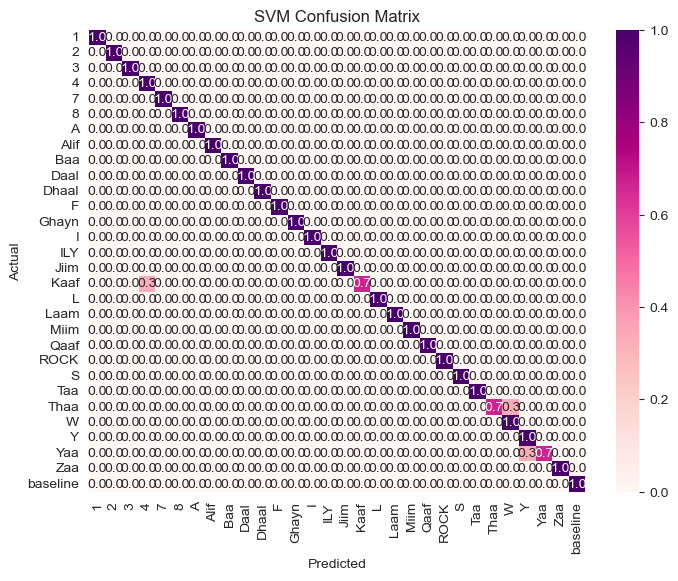

In [10]:
conf_matrix = confusion_matrix(y_test,y_pred_test)

# normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# define the labels for the x and y axes, by decoding the one hot encoded values
labels = label_encoder.inverse_transform(range(0,30))

# create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, cmap="RdPu", annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)

# set the title of the plot
plt.title("SVM Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("model2/FlexiCombo/images/svm_conf_matrix.png", dpi=300)

# show the plot
plt.show()

### RF

In [11]:
# Change for different results
cv = 4

# define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 150],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    #'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# create an RF model
rf_model_create = RandomForestClassifier(random_state=RANDOM_STATE)

# perform grid search to find the best hyperparameters
print("RF: Carrying out hyperparameter optimisation")
grid_search = GridSearchCV(estimator=rf_model_create, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# use the best model found by grid search to make predictions on the validation set
rf_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# use the trained Random Forest classifier to make predictions on the validation set
y_pred_val = rf_model.predict(X_val)
# evaluate the best model's accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)

val_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_val), 'pred': label_encoder.inverse_transform(y_pred_val)})

print(f"RF: Validation accuracy: {val_accuracy:.4f}")

val_comp.query("actual != pred")

RF: Carrying out hyperparameter optimisation


C:\Users\tobyb\anaconda3\envs\piezoSensorGlove\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}
Best score: 0.9809506531204645
RF: Validation accuracy: 1.0000


,actual,pred


In [12]:
# evaluate the best model's accuracy on the test set
y_pred_test = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

test_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_test), 'pred': label_encoder.inverse_transform(y_pred_test)})

print(f"RF: Test accuracy: {test_accuracy:.4f}")

# save the trained model to a file
print("RF: Saving model to file")
joblib.dump(rf_model, 'model2/FlexiCombo/rf_model.joblib')

test_comp.query("actual != pred")

RF: Test accuracy: 0.9556
RF: Saving model to file


,actual,pred
27,Thaa,W
68,Y,Yaa
84,Yaa,Y
85,Kaaf,4


In [13]:
print("RF: Evaluation")
print(classification_report(y_test,y_pred_test))

RF: Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      0.67      0.80         3
          17

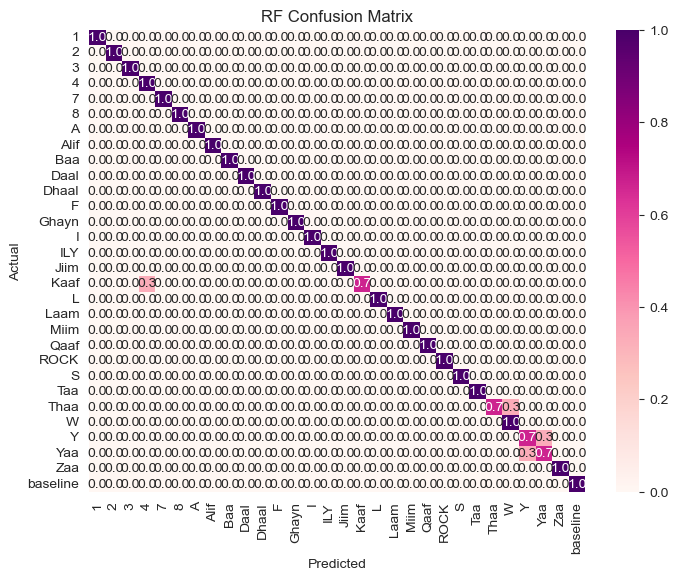

In [14]:
conf_matrix = confusion_matrix(y_test,y_pred_test)

# normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# define the labels for the x and y axes, by decoding the one hot encoded values
labels = label_encoder.inverse_transform(range(0,30))

# create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, cmap="RdPu", annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)

# set the title of the plot
plt.title("RF Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("model2/FlexiCombo/images/rf_conf_matrix.png", dpi=300)

# show the plot
plt.show()

### KNN

In [15]:
# Change for different results
cv = 4
# define the parameter grid to search over
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}
# create a KNN classifier and train it on the training data
knn_model_create = KNeighborsClassifier()

# perform grid search to find the best hyperparameters
print("kNN: Carrying out hyperparameter optimisation")
grid_search = GridSearchCV(estimator=knn_model_create, param_grid=param_grid, cv=cv, n_jobs=-1)
grid_search.fit(X_train, y_train)

# use the best model found by grid search to make predictions on the validation set
knn_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


# use the trained knn classifier to make predictions on the validation set
y_pred_val = knn_model.predict(X_val)
# evaluate the best model's accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)

val_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_val), 'pred': label_encoder.inverse_transform(y_pred_val)})

print(f"KNN: Validation accuracy: {val_accuracy:.4f}")

val_comp.query("actual != pred")

kNN: Carrying out hyperparameter optimisation
Best parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.961810595065312
KNN: Validation accuracy: 1.0000


,actual,pred


In [16]:
# evaluate the best model's accuracy on the test set
y_pred_test = knn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

test_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_test), 'pred': label_encoder.inverse_transform(y_pred_test)})

print(f"KNN: Test accuracy: {test_accuracy:.4f}")

# save the trained model to a file
print("KNN: Saving model to file")
joblib.dump(knn_model, 'model2/FlexiCombo/knn_model.joblib')

test_comp.query("actual != pred")

KNN: Test accuracy: 0.9556
KNN: Saving model to file


,actual,pred
27,Thaa,W
43,Qaaf,4
84,Yaa,Y
85,Kaaf,4


In [17]:
print("KNN: Evaluation")
print(classification_report(y_test,y_pred_test))

KNN: Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      0.67      0.80         3
          1

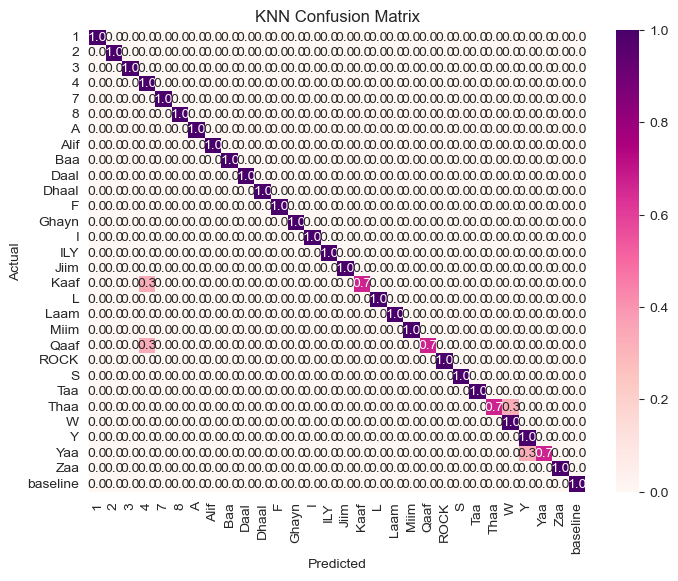

In [18]:
conf_matrix = confusion_matrix(y_test,y_pred_test)

# normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# define the labels for the x and y axes, by decoding the one hot encoded values
labels = label_encoder.inverse_transform(range(0,30))

# create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, cmap="RdPu", annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)

# set the title of the plot
plt.title("KNN Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("model2/FlexiCombo/images/knn_conf_matrix.png", dpi=300)

# show the plot
plt.show()

### ANN

In [19]:
#initialise
ann_model = tf.keras.models.Sequential()
#


ann_model.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann_model.add(tf.keras.layers.Dense(units=30, activation="softmax"))
ann_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

ann_model.fit(X_train,tf.keras.utils.to_categorical(y_train, 30),epochs = 1000)


Epoch 1/1000
7/7 [==============================] - 1s 2ms/step - loss: 3.4293 - accuracy: 0.0429
Epoch 2/1000
7/7 [==============================] - 0s 1ms/step - loss: 3.4232 - accuracy: 0.0286
Epoch 3/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.4173 - accuracy: 0.0381
Epoch 4/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.4119 - accuracy: 0.0286
Epoch 5/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.4066 - accuracy: 0.0190
Epoch 6/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.4015 - accuracy: 0.0095
Epoch 7/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.3968 - accuracy: 0.0095
Epoch 8/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.3922 - accuracy: 0.0048
Epoch 9/1000
7/7 [==============================] - 0s 2ms/step - loss: 3.3874 - accuracy: 0.0000e+00
Epoch 10/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.3821 - accuracy: 0.0095
Epoch 11/1000
7

In [20]:
val_loss, val_acc = ann_model.evaluate(X_val, tf.keras.utils.to_categorical(y_val, 30))

print('Validation accuracy:', val_acc)
val_comp.query("actual != pred")


y_pred_val = ann_model.predict(X_val)
y_pred_val_labels=np.argmax(y_pred_val, axis=1)
val_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_val), 'pred': label_encoder.inverse_transform(y_pred_val_labels)})

val_comp.query("actual != pred")

2/2 [==============================] - 1s 10ms/step - loss: 0.0431 - accuracy: 0.9811
Validation accuracy: 0.9811320900917053
2/2 [==============================] - 0s 10ms/step


,actual,pred
34,Thaa,W


In [21]:
test_loss, test_acc = ann_model.evaluate(X_test, tf.keras.utils.to_categorical(y_test, 30))

print('Test accuracy:', test_acc)

# save the trained model to a file
print("ANN: Saving model to file")
joblib.dump(ann_model, 'model2/FlexiCombo/ann_model.joblib')

y_pred_test = ann_model.predict(X_test)
y_pred_test_labels=np.argmax(y_pred_test, axis=1)
test_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_test), 'pred': label_encoder.inverse_transform(y_pred_test_labels)})

test_comp.query("actual != pred")

3/3 [==============================] - 0s 0s/step - loss: 0.1060 - accuracy: 0.9556
Test accuracy: 0.9555555582046509
ANN: Saving model to file
INFO:tensorflow:Assets written to: ram://9b11bae8-6e4c-4829-99a4-a0f3f2453001/assets
3/3 [==============================] - 0s 1ms/step


,actual,pred
27,Thaa,W
66,Dhaal,3
84,Yaa,Y
85,Kaaf,4


In [22]:
print("ANN: Evaluation")
print(classification_report(y_test,y_pred_test_labels))

ANN: Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      0.67      0.80         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      0.67      0.80         3
          1

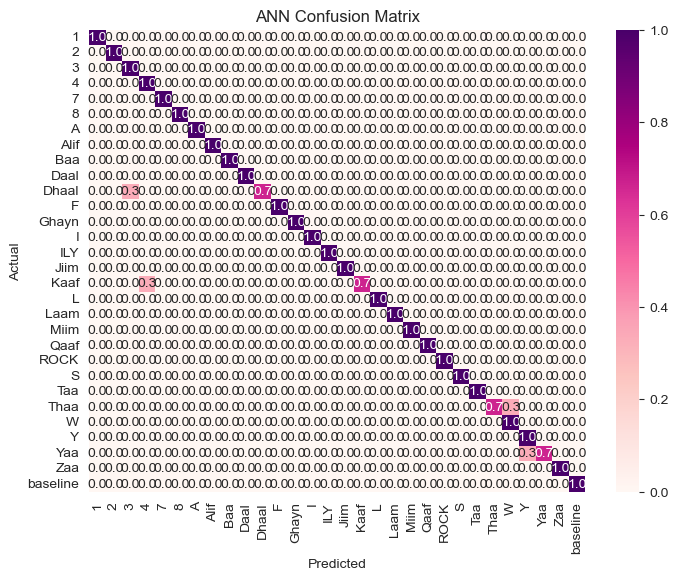

In [23]:
conf_matrix = confusion_matrix(y_test,y_pred_test_labels)

# normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# define the labels for the x and y axes, by decoding the one hot encoded values
labels = label_encoder.inverse_transform(range(0,30))

# create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, cmap="RdPu", annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)

# set the title of the plot
plt.title("ANN Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("model2/FlexiCombo/images/ann_conf_matrix.png", dpi=300)

# show the plot
plt.show()

### XGBoost

In [24]:
cv=4
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    #'subsample': [0.5, 0.7, 0.9],
    #'colsample_bytree': [0.5, 0.7, 0.9],
    #'reg_alpha': [0, 0.01, 0.1],
    #'reg_lambda': [0, 0.01, 0.1]
}
xgb_model = XGBClassifier()

print("XGBoost: Carrying out hyperparameter optimisation")
grid_search = GridSearchCV(xgb_model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# use the best model found by grid search to make predictions on the validation set
xgb_best_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


y_pred_val = xgb_best_model.predict(X_val)
# evaluate the best model's accuracy on the validation set
val_accuracy = accuracy_score(y_val, y_pred_val)

val_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_val), 'pred': label_encoder.inverse_transform(y_pred_val)})

print(f"XGBoost: Validation accuracy: {val_accuracy:.4f}")

val_comp.query("actual != pred")

XGBoost: Carrying out hyperparameter optimisation
Best parameters: {'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100}
Best score: 0.871643686502177
XGBoost: Validation accuracy: 0.9811


,actual,pred
34,Thaa,W


In [25]:
# evaluate the best model's accuracy on the test set
y_pred_test = xgb_best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

test_comp = pd.DataFrame({'actual': label_encoder.inverse_transform(y_test), 'pred': label_encoder.inverse_transform(y_pred_test)})

print(f"XGBoost: Test accuracy: {test_accuracy:.4f}")

# save the trained model to a file
print("XGBoost: Saving model to file")
joblib.dump(knn_model, 'model2/FlexiCombo/xgb_model.joblib')

test_comp.query("actual != pred")

XGBoost: Test accuracy: 0.8556
XGBoost: Saving model to file


,actual,pred
1,L,8
7,Taa,7
8,L,8
11,Taa,Zaa
26,Daal,Baa
27,Thaa,W
44,ROCK,7
49,Dhaal,Y
50,8,ILY
64,F,Miim


In [26]:
print("XGBoost: Evaluation")
print(classification_report(y_test,y_pred_test))

XGBoost: Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       0.60      1.00      0.75         3
           5       0.50      0.67      0.57         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       0.75      1.00      0.86         3
           9       1.00      0.67      0.80         3
          10       1.00      0.67      0.80         3
          11       1.00      0.67      0.80         3
          12       1.00      1.00      1.00         3
          13       1.00      0.67      0.80         3
          14       0.60      1.00      0.75         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
       

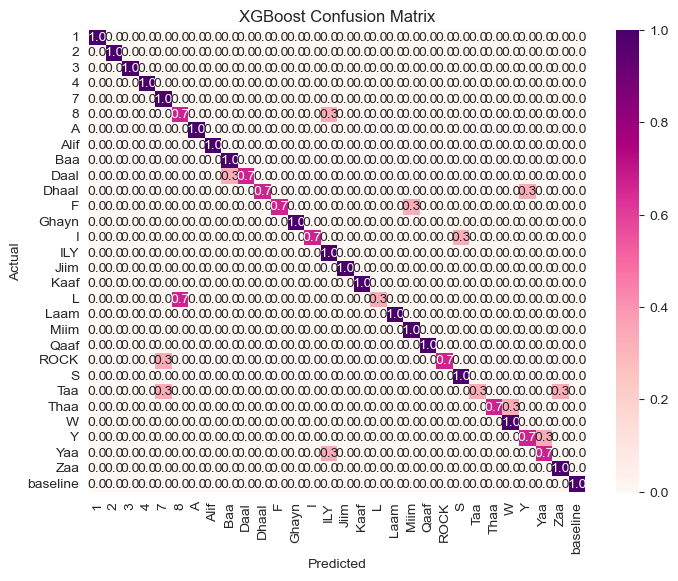

In [27]:
conf_matrix = confusion_matrix(y_test,y_pred_test)

# normalize the confusion matrix
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# define the labels for the x and y axes, by decoding the one hot encoded values
labels = label_encoder.inverse_transform(range(0,30))

# create a heatmap of the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_norm, cmap="RdPu", annot=True, fmt='.1f', xticklabels=labels, yticklabels=labels)

# set the title of the plot
plt.title("XGBoost Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.savefig("model2/FlexiCombo/images/xgb_conf_matrix.png", dpi=300)

# show the plot
plt.show()